# zerina project

## setup

In [1]:
import pandas as pd
import numpy as np
import scipy
from tqdm import tqdm_notebook, tnrange, trange, tqdm
from itertools import cycle
from collections import Counter

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## data processing

### transition matrices

In [27]:
#tmat_file = 'data/wifi_t_matrices.csv'
tmat_file = 'data/wifi_t_matrices2.csv'

tmat_df = (
    pd
    .read_csv(
        tmat_file, 
        names=['OnOn','OnOff','OffOn','OffOff','timestep']
    )
    #.eval('OffOff = 1 - OffOff')
    #.eval('OffOn = 1 - OffOn')
    [['OnOn', 'OnOff', 'OffOff', 'OffOn', 'timestep']]
)

tmat_df.head()

,OnOn,OnOff,OffOff,OffOn,timestep
0,0.99013,0.009865,0.000629,0.99937,5
1,0.88387,0.116130,0.008920,0.99108,105
2,0.79683,0.203170,0.016747,0.98325,205
3,0.75017,0.249830,0.024196,0.97580,305
4,0.71139,0.288610,0.030688,0.96931,405


### read csv and preprocess

In [3]:
tar_file = r'data/wifitrafficstats2.csv'
#tar_file = r'data/wifitrafficstats3.csv'
#tar_file = r'data/wifitrafficstats4.csv'
#tar_file = r'data/wifitrafficstats5.csv'
#tar_file = r'data/wifitrafficstats6.csv'

df = (
    pd
    .read_csv(tar_file)
    .rename({ 
        'Time':'time', 
        'Length':'length', 
        'TX Rate':'rate'
    }, axis=1)
    .eval('time = time * 1e6')
    .eval('rate = rate * 1e6')
    .eval('length = length * 8')
    .eval('on_time = 1e6 * length / rate')
    .eval('end_time = time + on_time')
    .assign(
        shift_time = lambda x: x.end_time.shift(1),
        off_time = lambda x: [
            (time - shift_time) 
                if (time - shift_time) > 0 else 0 
            for time, shift_time in (zip(x.time, x.shift_time))
    ])
    .drop(['No.','Delta Time','shift_time'], axis=1)
    .round(0)
)



df.head(10)

,time,length,rate,on_time,end_time,off_time
0,0.0,1352,6000000.0,225.0,225.0,0.0
1,36341.0,312,24000000.0,13.0,36354.0,36116.0
2,39469.0,312,24000000.0,13.0,39482.0,3115.0
3,49356.0,2288,1000000.0,2288.0,51644.0,9874.0
4,50556.0,1008,1000000.0,1008.0,51564.0,0.0
5,64737.0,6584,6000000.0,1097.0,65834.0,13173.0
6,82497.0,312,24000000.0,13.0,82510.0,16663.0
7,85683.0,312,24000000.0,13.0,85696.0,3173.0
8,101354.0,312,6000000.0,52.0,101406.0,15658.0
9,103643.0,456,12000000.0,38.0,103681.0,2237.0


## functions

### generate data list of `1`'s and `0`'s

In [28]:
def generate_data_list(df):
    '''
    takes dataframe with 'on_time' and 'off_time' time stamp columns 
    and returns a numpy array of 1's (on_time) and 0's (off_time)
    '''
    
    data_list = []

    for row in tqdm_notebook(df[['on_time','off_time']].iloc[1:].itertuples(), total=df.shape[0]-1):
        data_list.extend([1 for i in range(int(row.on_time))])
        data_list.extend([0 for i in range(int(row.off_time))])
    
    return np.array(data_list, copy=True)

### fast get all state lengths

In [29]:
def get_state_length_list(data):
    '''
    takes data list ([1,1,0,1,0,0,...]) and returns numpy array 
    of duration of consecutive bits ([13,245,2588,19,1056,...])
    '''
    
    data = np.array(data)    
    
    return np.diff(
        np.where(
            np.concatenate(
                ([data[0]],
                 data[:-1] != data[1:],
                 [0]
                )
            )
        )[0]
    )[::2]

### compute stats

In [30]:
def compute_stats(sim_matrix):
    sample_size = sim_matrix.shape[1]
    stats = sim_matrix.sum(axis=1)
                    
    state_lengths = [
        item for sublist in
        [
            list(get_state_length_list(sim_matrix[i,:]))
            for i in range(sim_matrix.shape[0])
        ]
        for item in sublist
    ]
    
    return {
        'mean': np.mean(stats) / sample_size,
        'std': np.std(stats) / sample_size,
        'state_lengths': Counter(state_lengths).most_common()
    }

## data simulator

### setup

In [31]:
def generate_sim_data(n_samples, m_trials, transition_matrix):
    '''
    takes a transition matrix and generates a simulated signal
    of size <length>
    '''
        
    cycle_dict = {
        (1,1,1): 0,
        (1,1,0): 1,
        (1,0,1): 2,
        (1,0,0): 1,
        (0,1,1): 1,
        (0,1,0): 2,
        (0,0,1): 1,
        (0,0,0): 0,
    }
    
    global p
    p = 0.5
    sim_matrix = np.zeros((m_trials, n_samples))
    
    state_cycler = cycle(transition_matrix)
    
    def cycle_states():
        return next(state_cycler)
    
    def generate_bit(n):
        global p
        
        if n == 0:
            return np.random.binomial(1, p)
            
        else:
            for i in range(n):
                p = cycle_states()

            return np.random.binomial(1, p)
        
    for i in tnrange(m_trials, leave=False):
        sim_data = [1,1,1]
        p = 0.5
        
        for _ in range(n_samples + 1):        
            new_bit = generate_bit(cycle_dict[tuple(sim_data[-3:])])        
            sim_data.append(new_bit)
            
        sim_matrix[i,:] = np.array(sim_data[4:])
    
    return sim_matrix
    

### single execution

### main loop

In [32]:
import time

In [33]:
start_time = time.time()

master_dictionary = {
    row.timestep: {}
    for row in tmat_df.itertuples()
}
sim_matrix_list = []

sample_size = int(1e4)
trial_size = 10

for row in tqdm_notebook(tmat_df.itertuples(), total=tmat_df.shape[0]):
    transition_matrix = [row.OnOn, row.OnOff, row.OffOff, row.OffOn]
    sim_matrix = generate_sim_data(sample_size, trial_size, transition_matrix)    
    
    sim_matrix_list.append(sim_matrix)
    master_dictionary[row.timestep] = compute_stats(sim_matrix)
    
print(f'total elapsed time: {(time.time() - start_time)/60:0.2f} minutes')


total elapsed time: 0.08 minutes


### post-run stats

In [101]:
df_dict = {
    tstep: (
        pd.DataFrame(
            stats['state_lengths'], 
            columns=['duration','frequency']
        )
        .sort_values('duration')
        .reset_index(drop=True)
        .assign(timestep = tstep)
    )
    for tstep, stats in master_dictionary.items()
}

full_df = pd.concat([df for df in df_dict.values()])
assert sum(df.shape[0] for df in df_dict.values()) == full_df.shape[0], 'missing rows'

stats_list = [
    {
        'timestep': timestep,
        'mean': stats['mean'],
        'std': stats['std']
    }
    for timestep, stats in master_dictionary.items()
]

stats_df = pd.DataFrame(stats_list)[['timestep','mean','std']]

### dev

In [103]:
full_df.head()

,duration,frequency,timestep
0,1,21192,5
1,2,7504,5
2,3,86,5
3,20,1,5
4,28,1,5


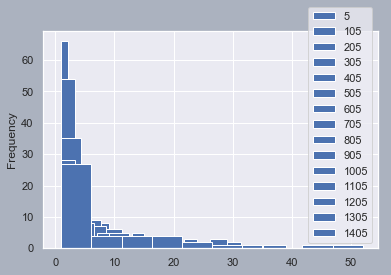

In [114]:
(full_df
 .loc[lambda x: x.duration > 10]
 .groupby('timestep')
 .frequency
 .plot
 .hist(subplots=True, legend=True)
);

## visualization

In [117]:
import altair as alt
from altair.expr import datum

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',rc={'figure.facecolor':'#ABB2BF'})

### state lengths vs timestep

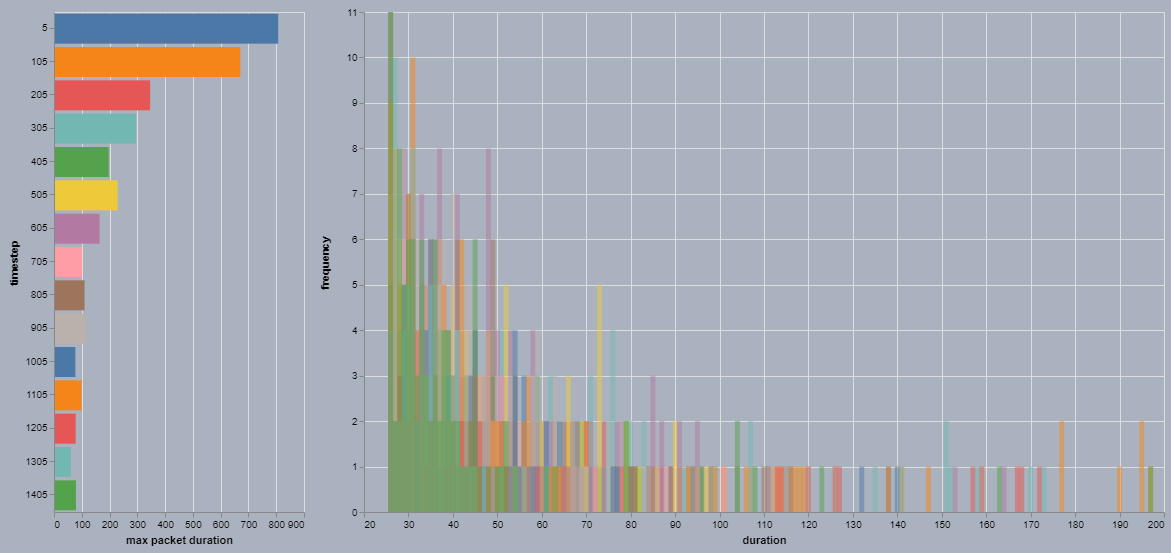

In [160]:
sel_timestep = alt.selection_multi(encodings=['y'])

bar_chart = alt.Chart(
    full_df,
    height=500,
    width=250
).mark_bar(
).encode(
    alt.X(
        'max(duration):Q',
        title='max packet duration'
    ),
    alt.Y(
        'timestep:N',
    ),
    color=alt.condition(
        sel_timestep,
        'timestep:N',
        alt.value('#96989b'),
        legend=None
    )
).add_selection(
    sel_timestep
)
#.configure(background='#abb2bf')



detail_chart = alt.Chart(
    full_df,
    height=500,
    width=800
).mark_bar(
    opacity=0.5
).transform_filter(
    sel_timestep
).transform_filter(
    datum.duration > 25
).transform_filter(
    datum.duration < 200
).encode(
    alt.X('duration:Q'),
    alt.Y(
        'frequency:Q', 
        #scale=alt.Scale(type='log')
    ),
    color=alt.Color('timestep:N', legend=None)
)
#.configure(background='#abb2bf')


alt.hconcat(
    bar_chart,
    detail_chart,
    background='#abb2bf'
)

### mean, std vs timestep

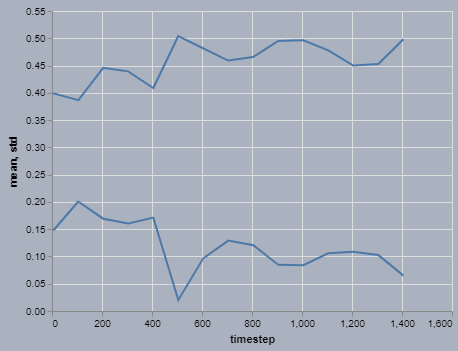

In [102]:
base = alt.Chart(
    stats_df
).mark_line(
).encode(
    alt.X('timestep:Q'),
    tooltip = [
        alt.Tooltip('timestep:Q'),
        alt.Tooltip('mean:Q'),
        alt.Tooltip('std:Q', format='0.2f')
    ]
)

alt.layer(
    base.encode(alt.Y('mean:Q')),
    base.encode(alt.Y('std:Q')),
    background='#abb2bf'
).interactive()

## output

#### write stats out

In [ ]:
stats_list = [
    {
        'timestep': timestep,
        'mean': stats['mean'],
        'std': stats['std']
    }
    for timestep, stats in master_dictionary.items()
]

pd.DataFrame(stats_list)[['timestep','mean','std']].to_csv('data/t_matrix_stats.csv', index=False)

#### write state lengths out

In [ ]:
max_len = max(set(len(stats['state_lengths']) for i, (_, stats) in enumerate(master_dictionary.items())))

state_length_matrix = np.zeros((tmat_df.shape[0], max_len))

for i, (_, stats) in enumerate(master_dictionary.items()):
    state_length_matrix[i,:(len(stats['state_lengths']))] = stats['state_lengths']

In [ ]:
np.savetxt('data/all_state_lengths.csv', state_length_matrix, delimiter=',')

#### alternate save

In [ ]:
import json
path = 'data/all_t_matrix_results.json'

try:
    with open(path, 'w') as file:
        json.dump(master_dictionary, file)
    print(f'successfully saved file to:\n{path}')
except Exception as e:
    print(f'uh oh, something went wrong\n{e}')

## real data ref